In [1]:
# isort:skip_file

# Treex

**Main features**:
* Modules contain their parameters
* Easy transfer learning
* Simple initialization
* No metaclass magic
* No apply method
* No need special versions of `vmap`, `jit`, and friends.

We will showcase each of the above features by creating a very contrived but complete module that will use everything from parameters, states, and random states:

In [2]:
from typing import Tuple

import jax.numpy as jnp
import numpy as np

import treex as tx


class NoisyLinear(tx.Module):
    # tree parts are defined by treex annotations
    w: tx.Parameter
    b: tx.Parameter
    rng: tx.Rng  # tx.Rng inherits from tx.State

    # other annotations are possible but ignored by type
    name: str

    def __init__(self, din, dout):
        # Initializers only expect RNG key
        self.w = tx.Initializer(lambda k: jax.random.uniform(k, shape=(din, dout)))
        self.b = tx.Initializer(lambda k: jax.random.uniform(k, shape=(dout,)))

        # random state is JUST state, we can keep it locally
        self.rng = tx.Initializer(lambda k: k)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        assert isinstance(self.rng, jnp.ndarray)

        # update state in place
        key, self.rng = jax.random.split(self.rng, 2)

        # your typical linear operation
        y = jnp.dot(x, self.w) + self.b

        # add noise for fun
        return y + 0.8 * jax.random.normal(key, shape=y.shape)


model = NoisyLinear(1, 1)

print(model)

NoisyLinear:
  w: Initializer
  b: Initializer
  rng: Initializer

Initialization is straightforward. The only thing you need to do is to call `init` on your module with a random key:

In [3]:
import jax

model = model.init(key=42)
print(model)

NoisyLinear:
  w: Parameter(1, 1) float32
  b: Parameter(1) float32
  rng: Rng(2) uint32

Now we will be reusing the previous NoisyLinear model, and we will create an optax optimizer that is used to train the model:

In [4]:
import optax

optimizer = tx.Optimizer(optax.adam(1e-2))

params = model.filter(tx.Parameter)
optimizer = optimizer.init(params)

print(f"{params=}")

NoisyLinear:
  w: Parameter(1, 1) float32
  b: Parameter(1) float32
  rng: Nothing

params=


Notice that we are already splitting the model into `params` and `states` since we only need to pass the `params` to the optimizer. Next, we will create the loss function, it will take the model parts and the data parts and return the loss plus the new states:

In [5]:
from functools import partial


@partial(jax.value_and_grad, has_aux=True)
def loss_fn(params: NoisyLinear, model: NoisyLinear, x, y):
    # update params into model
    model = model.update(params)
    # apply model
    pred_y = model(x)
    # MSE loss
    loss = jnp.mean((y - pred_y) ** 2)
    # return model with state updates
    return loss, model

Notice that we are merging the `params` and `states` into the complete model since we need everything in place to perform the forward pass. Also, we return the updated states from the model. The above steps are required because JAX functional API requires us to be explicit about state management.

**Note**: inside `loss_fn` (wrapped by `value_and_grad`) module can behave like a regular mutable Python object. However, every time it is treated as a pytree a new reference will be created in `jit`, `grad`, `vmap`, etc. It is essential to consider this when using functions like `vmap` inside a module, as JAX will need specific bookkeeping to manage the state correctly.

Next, we will implement the `update` function, it will look indistinguishable from your standard Haiku update, which also separates weights into `params` and `states`: 

In [6]:
@jax.jit
def train_step(model: NoisyLinear, optimizer: tx.Optimizer, x, y):
    # select Parameters
    params = model.filter(tx.Parameter)

    # call loss_fn to get loss, model state, and gradients
    (loss, model), grads = loss_fn(params, model, x, y)

    # apply optax update
    new_params = optimizer.update(grads, params)

    # update new_params
    model = model.update(new_params)

    return model, optimizer, loss

Before we start training lets get some data:

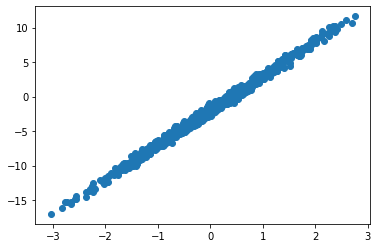

In [7]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)


def get_data(dataset_size: int) -> Tuple[np.ndarray, np.ndarray]:
    x = np.random.normal(size=(dataset_size, 1))
    y = 5 * x - 2 + 0.4 * np.random.normal(size=(dataset_size, 1))
    return x, y


def get_batch(
    data: Tuple[np.ndarray, np.ndarray], batch_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    idx = np.random.choice(len(data[0]), batch_size)
    return jax.tree_map(lambda x: x[idx], data)


data = get_data(1000)

plt.scatter(data[0], data[1])
plt.show()

Finally, we create a simple training loop that performs a few thousand updates and update `params` and `states` back into a single `model` at the end:

In [8]:
steps = 10_000

for step in range(steps):
    x, y = get_batch(data, batch_size=32)

    model, optimizer, loss = train_step(model, optimizer, x, y)

    if step % 1000 == 0:
        print(f"[{step}] loss = {loss}")

[0] loss = 19.93079376220703


[1000] loss = 1.0068186521530151
[2000] loss = 0.7745456695556641


[3000] loss = 0.7037231922149658
[4000] loss = 0.8157142400741577


[5000] loss = 0.6878036260604858
[6000] loss = 0.6529759764671326


[7000] loss = 0.9283773899078369
[8000] loss = 0.8058698177337646


[9000] loss = 0.8164499998092651


Now lets generate some test data and see how our model performed:

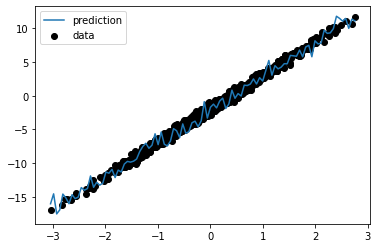

In [9]:
import matplotlib.pyplot as plt

X_test = np.linspace(data[0].min(), data[0].max(), 100)[:, None]
y_pred = model(X_test)

plt.scatter(data[0], data[1], label="data", color="k")
plt.plot(X_test, y_pred, label="prediction")
plt.legend()
plt.show()

We can see that the model has learned the general trend, but because of the `NoisyLinear` modules we have a bit of noise in the predictions.